# 1D Autoencoders

A coastal research buoy records 1D sonar pulses from otters, but storms add noise and sudden spikes that distort the signal. Each pulse is only a short sequence, yet it carries important information about movement and behavior. Your task is to build a small autoencoder that learns a compact 2D representation and reconstructs cleaner signals, so the team can spot the underlying patterns even during rough weather.

## Goals
- Build a tiny encoder and decoder using PyTorch
- Train a denoising autoencoder on synthetic 1D signals
- Visualize reconstructions and a 2D embedding map

## PyTorch
In this course, we use [PyTorch](https://pytorch.org) to build neural networks. PyTorch is an open-source library developed by Meta and widely used in research and industry. It is organized around three ideas: **tensors**, **automatic differentiation**, and **modules**.

### 1) Tensors
A tensor is an n-dimensional array, like NumPy, but with optional GPU support.
Key points:
- Create with `torch.tensor(...)`, `torch.zeros(...)`, or from NumPy using `torch.from_numpy(...)`.
- Move to GPU with `.to(device)` where `device = torch.device('cuda')` if available.
- Tensors have a `dtype` (e.g., `float32`) and a `shape` (e.g., `(batch, features)`).

### 2) Autograd (automatic differentiation)
PyTorch tracks operations to compute gradients with `.backward()`.
Key points:
- If `x.requires_grad = True`, PyTorch builds a computation graph for `x`.
- After computing a scalar loss, call `loss.backward()` to populate `.grad` on parameters.
- Use `torch.no_grad()` for inference to save memory and speed up evaluation.

### 3) Modules and Layers
Models are built by subclassing `nn.Module` and defining a `forward` method.
Common layers: `nn.Linear`, `nn.ReLU`, `nn.Conv2d`, `nn.Dropout`.
You can combine layers using `nn.Sequential(...)` for simple stacks.

### 4) Training Loop Pattern
A standard PyTorch training step looks like:
- `optimizer.zero_grad()`
- forward pass: `pred = model(x)`
- compute loss: `loss = loss_fn(pred, y)`
- backprop: `loss.backward()`
- update params: `optimizer.step()`

### 5) Data Loading
Use `TensorDataset` and `DataLoader` to handle batching and shuffling.
`DataLoader` yields mini-batches of tensors during training.

### 6) Evaluation Mode
Switch to evaluation with `model.eval()` and back to training with `model.train()`.
This matters for layers like Dropout and BatchNorm.

### 7) Quick References
- https://pytorch.org/tutorials/beginner/basics/intro.html
- https://pytorch.org/docs/stable/nn.html
- https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

Run the demo cells below to see these ideas in action.

In [1]:
# Imports and setup
# numpy: numeric arrays; matplotlib: plotting; torch: tensors and autograd
# nn: neural network layers; TensorDataset/DataLoader: batching utilities
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Consistent plot styling for the notebook
plt.rcParams["figure.figsize"] = (8, 3)
plt.rcParams["axes.grid"] = True

### PyTorch demos
These short examples show tensor operations, autograd, and a tiny training loop.

#### Tensor demo
This section shows basic tensor creation and inspection. A tensor is an n-dimensional array that stores numbers and has a shape (its size along each axis) and a dtype (the numeric type, like float32).

What to notice in the code:
- `torch.tensor([[1.0, 2.0], [3.0, 4.0]])` creates a 2x2 tensor from Python lists.
- `torch.randn(2, 2)` creates a 2x2 tensor with random values from a normal distribution.
- `x.shape` tells you the dimensions (rows, columns).
- `x.dtype` tells you the numeric type, which affects memory and precision.

We also do a simple tensor operation: `z = x + y`. This uses element-wise addition, so shapes must match. If shapes do not match, PyTorch will attempt broadcasting or raise an error.

The last lines show how to select a device. If a GPU is available, `device` will be set to `cuda`, and `x.to(device)` moves the tensor to the GPU. Otherwise, it stays on the CPU. You do not need a GPU to run this notebook, but it is useful to know how device placement works because large models train much faster on GPU.

In [2]:
# Tensor basics
# Create small tensors, inspect shape and dtype, and do element-wise math.
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
y = torch.randn(2, 2)

# Shape tells you the size along each axis; dtype is the numeric type.
print("x shape:", x.shape, "dtype:", x.dtype)
print("y mean:", y.mean().item())

# Element-wise addition (shapes must match or broadcast correctly).
z = x + y
print("z[0]:", z[0])

# Choose a device and move a tensor there (GPU if available).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = x.to(device)
print("device:", x.device)

x shape: torch.Size([2, 2]) dtype: torch.float32
y mean: 0.23257379233837128
z[0]: tensor([1.3367, 2.1288])
device: cuda:0


#### Autograd demo
This section demonstrates automatic differentiation. We define a simple function `y = x^2` and ask PyTorch to compute the derivative at a specific point.

Key ideas to follow:
- `requires_grad=True` tells PyTorch to track operations on that tensor.
- When we compute `y0 = x0 ** 2`, PyTorch builds a computation graph that remembers how `y0` was produced from `x0`.
- `y0.backward()` computes the gradient of `y0` with respect to `x0`. The result is stored in `x0.grad`.

The plotted tangent line is a visual way to understand gradients. The slope of the tangent line at `x0` is the derivative. For `y = x^2`, the derivative is `2x`, so at `x0 = 1.5` the slope should be about `3.0`. The plot helps connect the numeric gradient value to the geometry of the curve.

In deep learning, the same idea scales up: instead of a single number, you have many parameters, and `.backward()` computes gradients for all of them so an optimizer can update the model.

x0: 1.5 f(x0): 2.25 grad: 3.0


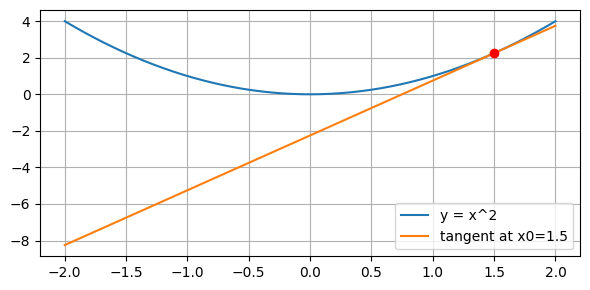

In [3]:
# Autograd example: f(x) = x^2 and its tangent line at x0
# requires_grad=True tells PyTorch to track operations on x0.
x0 = torch.tensor(1.5, requires_grad=True)
y0 = x0 ** 2

# backward() computes the derivative dy/dx at x0 and stores it in x0.grad.
y0.backward()
grad = x0.grad.item()

print("x0:", x0.item(), "f(x0):", y0.item(), "grad:", grad)

# Plot the function and tangent line to visualize the gradient.
xs = np.linspace(-2, 2, 200)
ys = xs ** 2

# Tangent line: y = f(x0) + f'(x0) * (x - x0)
tangent = y0.item() + grad * (xs - x0.item())

plt.figure(figsize=(6, 3))
plt.plot(xs, ys, label="y = x^2")
plt.plot(xs, tangent, label="tangent at x0=1.5")
plt.scatter([x0.item()], [y0.item()], color="red", zorder=3)
plt.legend()
plt.tight_layout()
plt.show()

#### Training loop demo
This section walks through a minimal training loop. We create synthetic data from a straight line with noise: `y = 2x + 0.5 + noise`. The goal is to learn the slope (2) and intercept (0.5) using a tiny model.

What the code is doing:
- We generate 60 random `x` values in the range [-1, 1], then compute `y` with a small amount of noise.
- `nn.Linear(1, 1)` creates a model with one input and one output. It has two parameters: a weight (slope) and a bias (intercept).
- `MSELoss` measures how far predictions are from the true values. Lower is better.
- `SGD` is a simple optimizer that updates parameters using gradients.

Training loop steps:
- `optimizer.zero_grad()` clears old gradients.
- `pred = lin_model(x_t)` runs a forward pass.
- `loss = loss_fn(pred, y_t)` computes the error.
- `loss.backward()` computes gradients.
- `optimizer.step()` updates the parameters.

The first plot shows the fitted line after training. You should see the line pass through the scatter of points. The second plot shows the loss decreasing over time, which means the model is improving. If the loss does not decrease, it usually means the learning rate is too high/low or the model is not learning the right patterns.

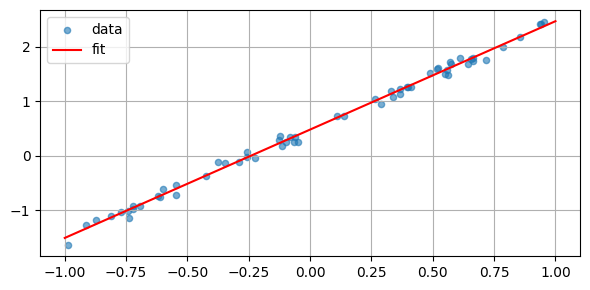

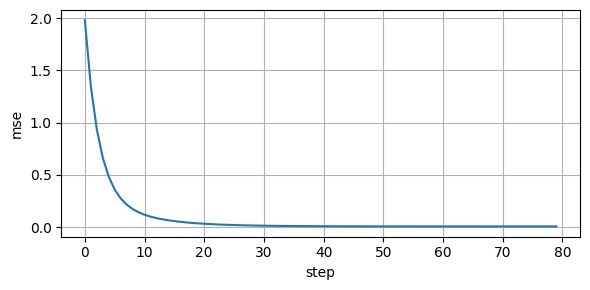

In [4]:
# Tiny training loop: fit y = 2x + 0.5 with a linear model
# Create synthetic data from a line plus noise.
rng = np.random.default_rng(42)
x_np = rng.uniform(-1, 1, size=(60, 1)).astype(np.float32)
noise = rng.normal(0, 0.1, size=(60, 1)).astype(np.float32)
y_np = 2.0 * x_np + 0.5 + noise

# Convert NumPy arrays to PyTorch tensors.
x_t = torch.from_numpy(x_np)
y_t = torch.from_numpy(y_np)

# A single-layer linear model has a weight and bias.
lin_model = nn.Linear(1, 1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(lin_model.parameters(), lr=0.1)

# Train for a small number of steps and record loss.
loss_history = []
for _ in range(80):
    optimizer.zero_grad()
    pred = lin_model(x_t)
    loss = loss_fn(pred, y_t)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

# Plot data and fitted line after training.
with torch.no_grad():
    x_line = torch.linspace(-1, 1, 100).view(-1, 1)
    y_line = lin_model(x_line)

plt.figure(figsize=(6, 3))
plt.scatter(x_np, y_np, s=20, alpha=0.6, label="data")
plt.plot(x_line.numpy(), y_line.numpy(), color="red", label="fit")
plt.legend()
plt.tight_layout()
plt.show()

# Plot the loss curve to confirm it decreases.
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.xlabel("step")
plt.ylabel("mse")
plt.tight_layout()
plt.show()

## Dataset: Synthetic 1D Signals
Now we get back to the autoencoders assignment. We will generate simple 1D signals with three patterns:
- **Calm**: a smooth sine wave
- **Splash**: a single bump
- **Chirp**: a rising-frequency wave

Then we add Gaussian noise and occasional spike glitches.

In [5]:
# Signal generation utilities
# make_clean_signal creates a single 1D pattern based on the chosen kind.
# We keep amplitude and phase fixed so the patterns are consistent.
def make_clean_signal(length, kind):
    t = np.linspace(0, 1, length)
    amp = 1.0
    phase = 0.0

    if kind == 0:  # calm: smooth sine wave
        signal = np.sin(2 * np.pi * t + phase)
    elif kind == 1:  # splash: a single Gaussian bump
        center = 0.5
        width = 0.08
        signal = np.exp(-0.5 * ((t - center) / width) ** 2)
    else:  # chirp: frequency increases over time
        signal = np.sin(2 * np.pi * (1 + 4 * t) * t + phase)

    return amp * signal


# generate_dataset creates clean/noisy pairs and simple labels.
def generate_dataset(n_samples=600, length=60, noise_std=0.2, outlier_prob=0.1, seed=42):
    rng = np.random.default_rng(seed)
    X_clean = np.zeros((n_samples, length), dtype=np.float32)
    X_noisy = np.zeros((n_samples, length), dtype=np.float32)
    labels = np.zeros(n_samples, dtype=int)

    for i in range(n_samples):
        kind = int(rng.integers(0, 3))
        clean = make_clean_signal(length, kind)
        noisy = clean + rng.normal(0, noise_std, size=length)

        # Add an occasional spike to mimic sensor glitches.
        if rng.random() < outlier_prob:
            spike_idx = int(rng.integers(0, length))
            noisy[spike_idx] += rng.uniform(-2.0, 2.0)

        X_clean[i] = clean
        X_noisy[i] = noisy
        labels[i] = kind

    return X_clean, X_noisy, labels

In [6]:
# Generate a small dataset
signal_len = 60
X_clean, X_noisy, labels = generate_dataset(n_samples=600, length=signal_len, seed=42)

# Train/test split with a fixed random permutation.
rng = np.random.default_rng(42)
idx = rng.permutation(len(X_clean))
train_size = int(0.8 * len(X_clean))
train_idx = idx[:train_size]
test_idx = idx[train_size:]

# Split clean/noisy signals and labels for training and testing.
X_train_clean = X_clean[train_idx]
X_train_noisy = X_noisy[train_idx]
X_test_clean = X_clean[test_idx]
X_test_noisy = X_noisy[test_idx]
labels_train = labels[train_idx]
labels_test = labels[test_idx]

print("Train shape:", X_train_noisy.shape)
print("Test shape:", X_test_noisy.shape)

Train shape: (480, 60)
Test shape: (120, 60)


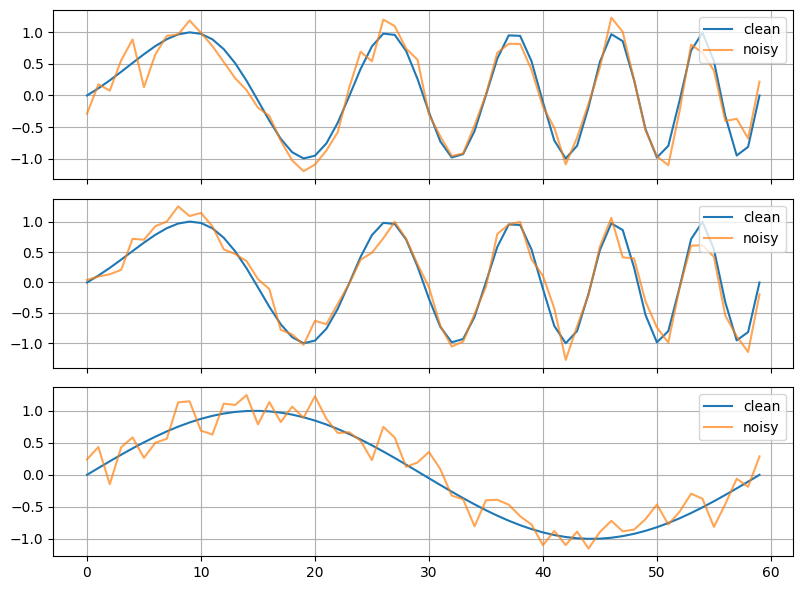

In [7]:
# Quick look at noisy vs clean signals
# We sample a few random indices and plot clean and noisy overlays.
rng = np.random.default_rng(42)
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for ax in axes:
    i = int(rng.integers(0, len(X_train_noisy)))
    ax.plot(X_train_clean[i], label="clean")
    ax.plot(X_train_noisy[i], label="noisy", alpha=0.7)
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Task 1: Define the Input and Embedding
You will store two integers that describe the model input and the size of the latent space.

Steps:
- Determine the number of features per signal (the second dimension of the training data).
- Choose an embedding size of 2 so you can visualize a 2D latent space.

Example:
```
example_data = np.zeros((num_samples, num_features))
example_input_dim = example_data.shape[1]
example_embedding_dim = embedding_size
```

Now apply the same idea to the real training data and set the embedding size to 2.

In [8]:
# Determine input dimension from the training data.
# Keep embedding_dim = 2 for a 2D latent space plot later.
# YOUR CODE HERE
input_dim = X_train_noisy.shape[1]
embedding_dim = 2

In [9]:
assert input_dim == X_train_noisy.shape[1]
assert embedding_dim == 2

## Task 2: Build the Autoencoder
You will implement a small `nn.Module` with an encoder and decoder.

Encoder architecture (input -> 32 -> embedding):
- `nn.Linear(input_dim, 32)`
- `nn.ReLU()`
- `nn.Linear(32, embedding_dim)`

Decoder architecture (embedding -> 32 -> input):
- `nn.Linear(embedding_dim, 32)`
- `nn.ReLU()`
- `nn.Linear(32, input_dim)`

Steps inside `__init__`:
- Build the encoder with `nn.Sequential(...)` and store it as `self.encoder`.
- Build the decoder with `nn.Sequential(...)` and store it as `self.decoder`.

Steps inside `forward`:
- Pass `x` through the encoder to get `z`.
- Pass `z` through the decoder to get the reconstruction.
- Return the reconstruction.

Example of `nn.Sequential`:
```
example_stack = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim)
)
```

Use the encoder and decoder sizes listed above for your model.

In [11]:
class Autoencoder(nn.Module):
    # A small encoder-decoder network using linear layers.
    def __init__(self, input_dim, embedding_dim):
        super().__init__()
        # Build encoder and decoder stacks with nn.Sequential.
        # YOUR CODE HERE
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        # Encode then decode to reconstruct the input.
        # YOUR CODE HERE
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
# Create the autoencoder using the input and embedding sizes.
# YOUR CODE HERE
model = Autoencoder(input_dim=input_dim, embedding_dim=embedding_dim)

# Small shape check: a batch of 4 should return shape (4, input_dim).
# Use the model's device in case it was moved to GPU.
with torch.no_grad():
    device = next(model.parameters()).device
    test_out = model(torch.zeros(4, input_dim, device=device))

In [13]:
assert test_out.shape == (4, input_dim)

## Task 3: Set Up Loss and Optimizer
You will define the loss function and optimizer used in training.

Steps:
- Use mean squared error for the loss.
- Use Adam for optimization with a learning rate of 1e-3.

Example:
```
example_model = nn.Linear(input_dim, output_dim)
example_loss = nn.MSELoss()
example_opt = torch.optim.SGD(example_model.parameters(), lr=learning_rate)
```

Follow the steps above, but use Adam and the provided model.

In [14]:
# Define the loss function and optimizer for training.
# YOUR CODE HERE
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Confirm the optimizer type.
### TEST {"name": "test_optimizer", "points": 5, "description": "optimizer defined"}
assert isinstance(optimizer, torch.optim.Adam)

## Training
We train the autoencoder to map noisy inputs to clean outputs.

Inside the loop, follow the standard PyTorch pattern:
- `optimizer.zero_grad()`
- forward pass to get predictions
- compute the loss
- backprop with `loss.backward()`
- update parameters with `optimizer.step()`

Example:
```
for batch_x, batch_y in loader:
    optimizer.zero_grad()
    preds = model(batch_x)
    loss = loss_fn(preds, batch_y)
    loss.backward()
    optimizer.step()
```

Use the batch variables provided in the code cell below.

In [16]:
# Create DataLoader for mini-batch training.
train_dataset = TensorDataset(
    torch.from_numpy(X_train_noisy),
    torch.from_numpy(X_train_clean)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [17]:
# Train the model for a fixed number of epochs.
num_epochs = 15
losses = []

# Use the model's device so training works on CPU or GPU.
device = next(model.parameters()).device

model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_noisy, batch_clean in train_loader:
        # Standard PyTorch training step.
        optimizer.zero_grad()
        batch_noisy = batch_noisy.to(device)
        batch_clean = batch_clean.to(device)
        # YOUR CODE HERE
        outputs = model(batch_noisy)
        loss = loss_fn(outputs, batch_clean)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(batch_noisy)

    # Average loss for the epoch.
    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)

print("Final training loss:", round(losses[-1], 4))

Final training loss: 0.0034


In [18]:
assert losses[-1] < losses[0]

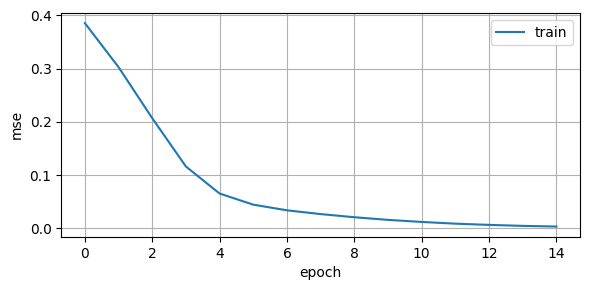

In [19]:
# Loss curve over epochs to visualize training progress.
plt.figure(figsize=(6, 3))
plt.plot(losses, label="train")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.tight_layout()
plt.show()

## Task 4: Reconstruct and Evaluate
Compute reconstructions on the test set and compare them to the noisy baseline.

Steps:
- Switch to evaluation mode with `model.eval()`.
- Use `torch.no_grad()` to disable gradient tracking.
- Run the model on the noisy test data and convert the output to NumPy.
- Compute two MSE values:
  - `baseline_mse`: between the noisy and clean test signals.
  - `recon_mse`: between the reconstructed and clean test signals.

Example:
```
model.eval()
with torch.no_grad():
    preds = model(eval_inputs)
```

You should see `recon_mse` smaller than `baseline_mse`.

In [22]:
# Prepare test tensors and compute reconstructions.
device = next(model.parameters()).device
X_test_noisy_t = torch.from_numpy(X_test_noisy).to(device)
X_test_clean_t = torch.from_numpy(X_test_clean).to(device)

# YOUR CODE HERE
model.eval()
with torch.no_grad():
    X_test_recon_t = model(X_test_noisy_t)
    X_test_recon = X_test_recon_t.cpu().numpy()
# Compute baseline and reconstruction MSE on the test set.
baseline_mse = np.mean((X_test_noisy - X_test_clean) ** 2)
recon_mse = np.mean((X_test_recon - X_test_clean) ** 2)
    
print("Baseline MSE:", round(baseline_mse, 4))
print("Reconstruction MSE:", round(recon_mse, 4))

Baseline MSE: 0.0404
Reconstruction MSE: 0.0028


In [23]:
assert recon_mse < baseline_mse

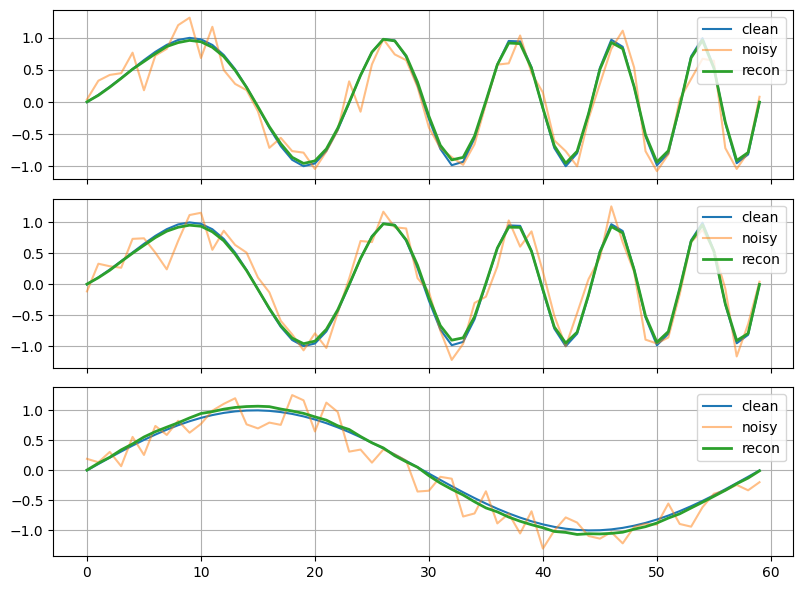

In [24]:
# Visualize a few reconstructions side-by-side.
rng = np.random.default_rng(42)
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for ax in axes:
    i = int(rng.integers(0, len(X_test_noisy)))
    ax.plot(X_test_clean[i], label="clean")
    ax.plot(X_test_noisy[i], label="noisy", alpha=0.5)
    ax.plot(X_test_recon[i], label="recon", linewidth=2)
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## 2D Embedding Map
The encoder compresses each 60-point signal into just 2 numbers. Think of those two numbers as coordinates on a 2D map.

How to read this plot:
- Each dot represents one test signal after it has been compressed by the encoder.
- Signals with similar shapes should end up near each other because the encoder learns to group similar patterns in the same region.
- Different signal types (calm, splash, chirp) may form clusters if the encoder captures those differences.

Why this matters:
- The 2D space is a compact summary of the original signal.
- If the clusters separate, the embedding contains useful structure beyond simple denoising.
- Even if clusters overlap, you can still see which dimensions the model uses to organize the data.

After you run the cell, look for clusters or trends along the axes and compare them to the signal types.

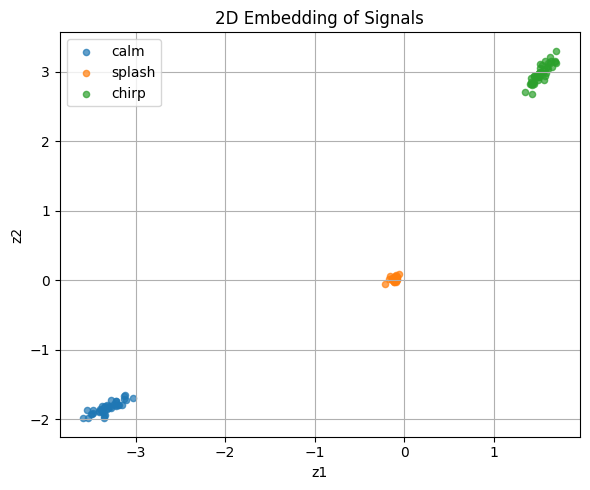

In [25]:
# Extract 2D embeddings and plot them by class.
device = next(model.parameters()).device
X_test_noisy_t = torch.from_numpy(X_test_noisy).to(device)
with torch.no_grad():
    embeddings = model.encoder(X_test_noisy_t).detach().cpu().numpy()

class_names = {0: "calm", 1: "splash", 2: "chirp"}
colors = ["tab:blue", "tab:orange", "tab:green"]

plt.figure(figsize=(6, 5))
for k in range(3):
    mask = labels_test == k
    plt.scatter(embeddings[mask, 0], embeddings[mask, 1], s=20, alpha=0.7, label=class_names[k], color=colors[k])
plt.title("2D Embedding of Signals")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.tight_layout()
plt.show()

## Finished
Congratulations! You built and trained a denoising autoencoder, evaluated reconstructions, and visualized a 2D embedding.

## Reflection (Not Graded)
- What patterns do you see in the 2D embedding?
- How did the reconstruction compare to the noisy input?
- If you increased `embedding_dim`, what might change?